In [1]:
import os
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.applications.vgg16 import decode_predictions
import cv2

In [2]:
train_data = os.path.join('train')
test_data = os.path.join('test')
val_data = os.path.join('val')

def preprocess_input_vgg(img):
    return preprocess_input(img)

# Configuração do gerador de dados para pré-processamento e aumento de dados
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg,
    rescale=1./255,         # Normaliza os valores dos pixels para o intervalo [0, 1]
    shear_range=0.2,        # Aplica corte aleatório
    zoom_range=0.2,         # Aplica zoom aleatório
    horizontal_flip=True,   # Inverte aleatoriamente as imagens horizontalmente
)

# Carrega e pré-processa as imagens de treinamento
train_dataset = datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),  # Tamanho das imagens esperado pela InceptionV3
    batch_size=64,
    class_mode='categorical', # 'categorical' se for classificação com mais de duas classes
    #subset='training'        # Especifica se é para conjunto de treinamento
    
)

# Carrega e pré-processa as imagens de validação
test_dataset = datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    #subset='validation'      # Especifica se é para conjunto de validação
)

# Carrega e pré-processa as imagens de validação
val_dataset = datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    #subset='validation'      # Especifica se é para conjunto de validação
)

Found 18325 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


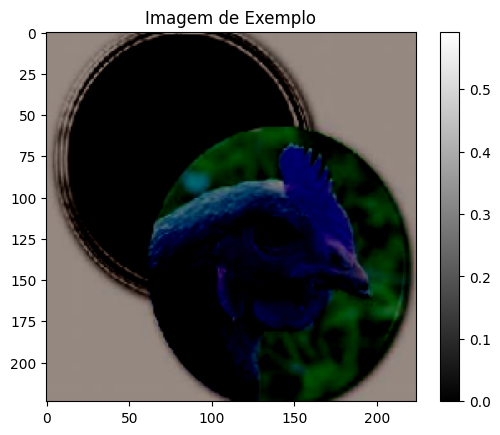

ValueError: Asked to retrieve element 91, but the Sequence has length 62

In [3]:
random_train_1 = np.random.randint(0, 572)
random_train_2 = np.random.randint(0, 31)

random_test_val_1 = np.random.randint(0, 122)
random_test_val_2 = np.random.randint(0, 20)


plt.imshow(train_dataset[random_train_1][0][random_train_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()
plt.imshow(test_dataset[random_test_val_1][0][random_test_val_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()
plt.imshow(val_dataset[random_test_val_1][0][random_test_val_2], cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
plt.title('Imagem de Exemplo')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()

In [4]:
# Passo 1: Carregar modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Passo 2: Congelar camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Passo 3: Adicionar camadas personalizadas no topo
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))  # Substitua 10 pelo número de suas classes

# Passo 4: Configurar e compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-7),  # Ajuste conforme necessário
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(train_dataset, epochs=30, batch_size=64, validation_data=val_dataset)  # Ajuste conforme necessário

model.summary()

Epoch 1/30
287/287 [==============================] - 1340s 5s/step - loss: 2.4668 - accuracy: 0.1007 - val_loss: 2.3349 - val_accuracy: 0.0961
Epoch 2/30
287/287 [==============================] - 1368s 5s/step - loss: 2.3685 - accuracy: 0.1161 - val_loss: 2.2498 - val_accuracy: 0.1264
Epoch 3/30
287/287 [==============================] - 1377s 5s/step - loss: 2.2995 - accuracy: 0.1422 - val_loss: 2.1948 - val_accuracy: 0.1901
Epoch 4/30
287/287 [==============================] - 1369s 5s/step - loss: 2.2528 - accuracy: 0.1708 - val_loss: 2.1528 - val_accuracy: 0.2520
Epoch 5/30
287/287 [==============================] - 1369s 5s/step - loss: 2.2136 - accuracy: 0.1987 - val_loss: 2.1237 - val_accuracy: 0.2711
Epoch 6/30
287/287 [==============================] - 1369s 5s/step - loss: 2.1836 - accuracy: 0.2200 - val_loss: 2.0876 - val_accuracy: 0.3027
Epoch 7/30
287/287 [==============================] - 1368s 5s/step - loss: 2.1566 - accuracy: 0.2373 - val_loss: 2.0619 - val_accuracy:

In [ ]:
model = Sequential()

# Bloco 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Bloco 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Camada Flatten
model.add(Flatten())

# Camadas Densas
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=15, batch_size=64, validation_data=test_dataset)

In [ ]:
target_names = ['Aranha', 'Borboleta', 'Cachorro', 'Cavalo', 'Elefante', 'Esquilo', 'Galinha', 'Gato', 'Ovelha', 'Vaca']
predictions = model.predict(test_dataset)

# print(np.argmax(predictions, axis=1))
# plt.imshow(test_dataset, cmap='gray')  # cmap é o mapa de cores, 'gray' para uma imagem em tons de cinza
# plt.title('Imagem de Exemplo')

# plt.colorbar()  # Adiciona uma barra de cores para referência
# y_pred_array = np.argmax(predictions, axis=1)

y_pred = np.argmax(predictions, axis=1)
# test_dataset
y_true = test_dataset.classes
# print(test_dataset.class_indices)
report = classification_report(y_true, y_pred, target_names=target_names)
# print(report)

# maior = np.argmax([0, 1, 2, 3, 4, 5, 6, 7, 88, 9])
# print(maior)

In [ ]:
y_pred = np.argmax(predictions, axis=1)
# test_dataset
y_true = test_dataset.classes
# print(test_dataset.class_indices)
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

for i in range(0, 61):
    print("Predito: ", y_pred[i], "Correto: ", y_true[i])

              precision    recall  f1-score   support

      Aranha       0.18      0.18      0.18       723
   Borboleta       0.08      0.07      0.07       313
    Cachorro       0.19      0.20      0.20       730
      Cavalo       0.11      0.14      0.12       394
    Elefante       0.04      0.04      0.04       217
     Esquilo       0.10      0.10      0.10       280
     Galinha       0.14      0.14      0.14       465
        Gato       0.06      0.05      0.06       250
      Ovelha       0.09      0.05      0.07       273
        Vaca       0.06      0.06      0.06       280

    accuracy                           0.13      3925
   macro avg       0.10      0.10      0.10      3925
weighted avg       0.13      0.13      0.13      3925

Predito:  1 Correto:  0
Predito:  0 Correto:  0
Predito:  5 Correto:  0
Predito:  0 Correto:  0
Predito:  3 Correto:  0
Predito:  9 Correto:  0
Predito:  7 Correto:  0
Predito:  2 Correto:  0
Predito:  9 Correto:  0
Predito:  6 Correto:  0
P

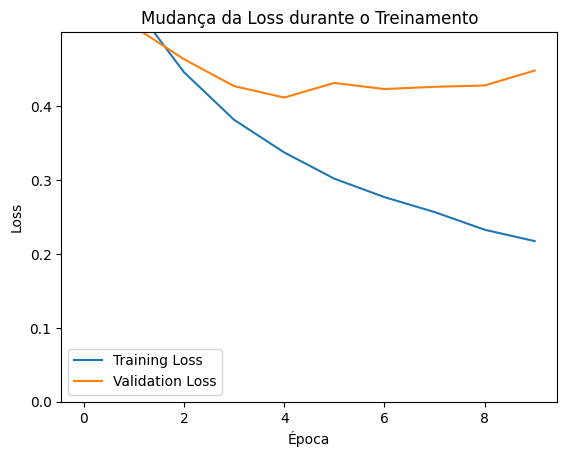

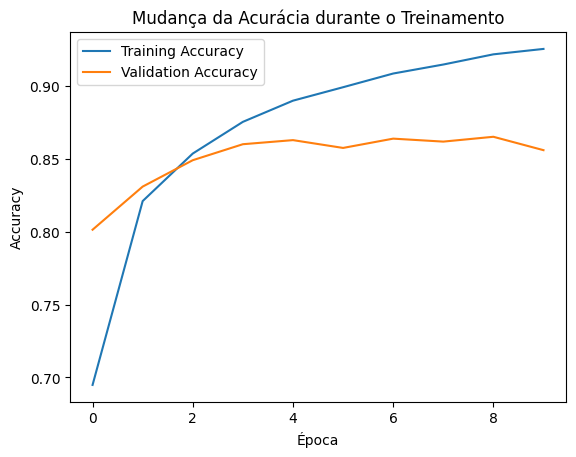

In [6]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# print("Accuracy:", metrics.accuracy_score(y_pred_array, y_true))
# print("F1-score:", metrics.f1_score(y_pred_array, y_true, average='micro'))
# print("Precision:", metrics.precision_score(y_pred_array, y_true, average='micro'))
# print("Recall:", metrics.recall_score(y_pred_array, y_true, average='micro'))

plt.ylim(0, 0.5)
plt.yticks(np.arange(0, 0.5, 0.1))

# Plotagem da loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Mudança da Loss durante o Treinamento')
plt.legend()
plt.show()
# Plotagem da accuracy
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Mudança da Acurácia durante o Treinamento')
plt.legend()
plt.show()